# CCUR FS 2022 - Toy Model Exercise 1

Exercise instruction PDF: https://moodle-app2.let.ethz.ch/pluginfile.php/1293973/mod_resource/content/1/Instructions_ToyModel_Exercise_FS2022.pdf

__Insert your name here__ (e.g. __Group 10:__ Larisa Darplt, Haonan Yang, and Christossy Lalika)

In [2]:
%matplotlib inline

## Load packages
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import random

from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots

import pylab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.lines import Line2D

In [3]:
## Some plotting defaults
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'mathtext.default':'regular'}) 

In [4]:
## Folder needs to be adapted to where you saved it
#dir_in_data  = '/Your/specific/directory/' ## If you work on your machine
dir_in_data  = 'data/'                     ## If you work on Jupyter Hub          

## Load the data
si_short = pd.read_pickle(os.path.join(dir_in_data,'FS2022_SI_obs.pkl'))

## 1. Statistical modeling of past observations
### Deterministic part – the trend

__1.a) What are the corresponding regression coefficients $\beta_0$ and $\beta_1$ (where the intercept should be estimated for the first time step January 1997)?__

In [5]:
res = stats.linregress(range(180),si_short)
intercept = res.intercept
slope = res.slope

print('beta0: %.2f m/s' %intercept)
print('beta1: %.5f m/s/month' %slope)

beta0: 13.86 m/s
beta1: 0.00523 m/s/month


__1.b) What other (more robust) method could be applied to estimate the trend?__

(1) Thein-Sen trend estimate: taking the median as slope estimate among all slopes constructed by all pairs of observations;\
(2) Robust regression: more robust regression with outliers by assigning weights to observations based on the residuals.

__1.c) Assuming the linear regression model to be valid, is the trend significant on a 5 % level?__

In [6]:
pval = res.pvalue

print('The p-value is %.3e' %pval)

The p-value is 6.456e-08


Less than 5% so significant

__1.d)	What are the assumptions on the residuals for the linear regression and are they fulfilled? Discuss each assumption with a plot and 1-2 sentences using the detrended data. You can use the functions ```plt.hist()```, ```stats.probplot()``` and ```acf()```/```pacf()```, and plot the residuals against the fitted values (Tukey Anscombe plot).__

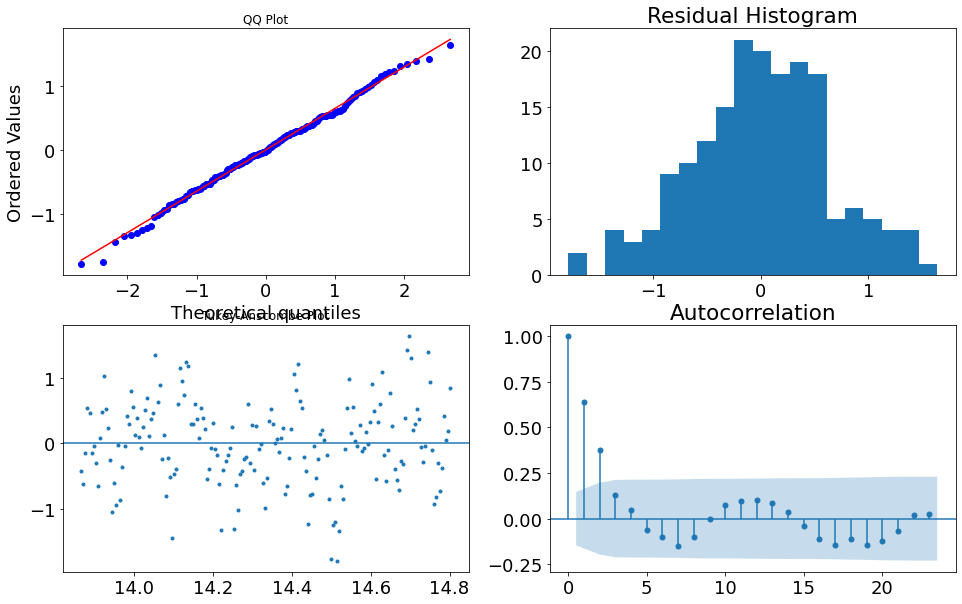

In [7]:
y_hat = intercept + slope * range(180)
residuals = [si_short[i] - y_hat[i] for i in range(180)]

fig, axs = plt.subplots(2,2, figsize = (16,10))
res = stats.probplot(residuals, plot = axs[0][0])
axs[0][0].set_title('QQ Plot', size = 12)
axs[0][1].hist(residuals, bins=20)
axs[0][1].set_title('Residual Histogram')
axs[1][0].plot(y_hat, residuals, '.')
axs[1][0].axhline(0)
axs[1][0].set_title('Tukey-Anscombe Plot', size = 12)
statsmodels.graphics.tsaplots.plot_acf(pd.Series(residuals), ax = axs[1][1])
#statsmodels.graphics.tsaplots.plot_pacf(pd.Series(residuals), ax = axs[1][1])
plt.show()

#plt.bar(range(len(acf(pd.Series(residuals)))),acf(pd.Series(residuals)))
#plt.bar(range(len(pacf(pd.Series(residuals)))),pacf(pd.Series(residuals)))

the assumptions on the residuals for the linear regression are:\
(1) Residuals follow normal distribution;\
(2) Residuals have constant variance (identically distributed);\
(3) Residuals are independent (i.e. no serial correlation).

* Looking at the __histogram__ and __QQ-plot__, we can conclude that the residuals basically follow normal distribution (histogram shows a bit left-skewness).
* Looking at the __Tukey-Ascombe plot__, we can conclude the residuals have constant variance and no systematic error.
* Looking at the __ACF and PACF plot__, we can conclude the residuals are autocorrelated.

__1.e) Can you come up with physical explanations for the outcome of 1.d)? Write maximal two sentences.__

Storms are not i.i.d events and is itself an auto-correlated.

__1.f) What is the order (p) of the auto-regressive process leading to the partial autocorrelation observed in the residuals? Have a look at the plot you created in 1.d) using ```acf()```/```pacf()```. What is the partial auto-correlation α of the lag-1?__


The lag-1 autocorrelation is 0.642


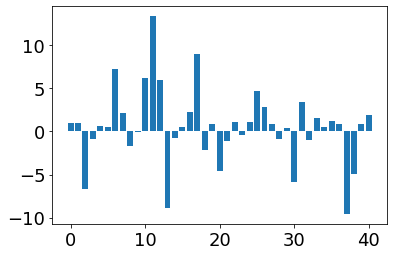

In [10]:
plt.bar(range(len(pacf(pd.Series(residuals)))),acf(pd.Series(residuals)) / pacf(pd.Series(residuals)))
autocorr = pacf(pd.Series(residuals))[1]

print('The lag-1 autocorrelation is %.3f' %autocorr)

the order (p) of the auto-regressive process leading to the partial autocorrelation observed in the residuals is 1 according to the PACF.

__1.g) How does the autocorrelation affect the trend estimate $\beta_1$ (c.f. 1.a) and the variance thereof? What does this imply for the significance of the trend you have estimated in 1.c)?__

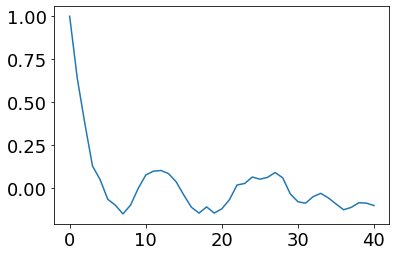

In [11]:
plt.plot(np.arange(41),acf(pd.Series(residuals)))

The autocorrelation decreases the validity of the t, F and chi-squared distributions, causing high variance of trend estimation; there is inefficient estimation and prediction of the regression vector. Thus, the trend estimated is biased and needs correction.

__1.h) What is the standard deviation (σ) of $w_t$ assuming a normal distribution? Remember that $w_t = \epsilon_t - \epsilon_{t-1} \cdot \alpha$ according to equation (2).__

In [14]:
mean, sigma_w = stats.norm.fit(pd.Series([(residuals[i] - residuals[i-1] * autocorr) for i in range(1, len(residuals))])[:-1])

In [15]:
# <your code>

print('The standard deviation of w_t is: %.3f m/s' %sigma_w)

The standard deviation of w_t is: 0.492 m/s


### Reproduce observations – Trend + AR(1)

__1.i) Generate one realisation of your model and compare it (visually) with the observations.__

Figure(432x288)


/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


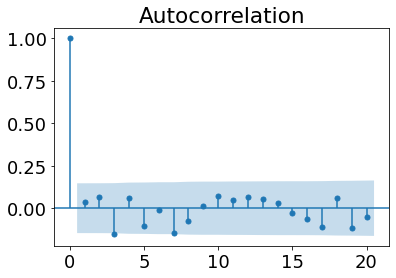

In [16]:
# pre-whitening
W = [((si_short[i] - autocorr * si_short[i-1]) / (1 - autocorr)) for i in range(1, len(si_short))]
res2 = stats.linregress(range(179), W)
y_hat2 = res2.intercept + res2.slope * range(179)
residuals2 = [W[i] - y_hat2[i] for i in range(179)]
print(statsmodels.graphics.tsaplots.plot_acf(pd.Series(residuals2), lags = 20))

# We could see autocorrelation are all non-significant, thus we don't need further iteration.

residuals = residuals2
intercept = res2.intercept
slope = res2.slope
autocorr = pacf(pd.Series(residuals))[1]

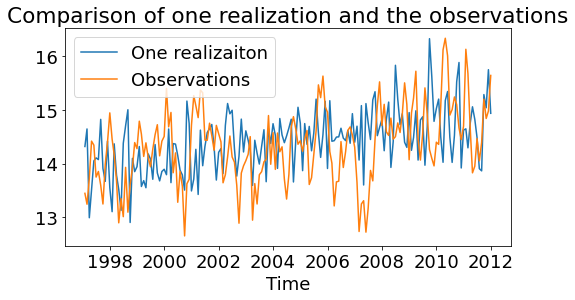

In [17]:
# one realisation
def one_simulation(intercept = intercept, slope = slope, autocorr = autocorr, sigma_w = sigma_w, obs_num = 180, ini_epi = None):
    random_truncate = random.randint(1, 10) # randomly truncate the epi to avoid initialization problem
    wt = np.random.normal(mean, sigma_w, obs_num + random_truncate)
    epi = np.array([None] * (obs_num + random_truncate))
    if ini_epi is None:
        for i in range(len(epi)):
            if i==0:
                epi[i] = wt[i]
            else:
                epi[i] = epi[i-1] * autocorr + wt[i]  
        epi = epi[random_truncate:]
        x = np.arange(obs_num) * slope + intercept + epi
    else:
        for i in range(len(epi)):
            if i==0:
                epi[i] = ini_epi
            else:
                epi[i] = epi[i-1] * autocorr + wt[i]  
        epi = epi[random_truncate:]
        x = np.arange(obs_num) * slope + intercept + epi
    return x

random.seed(12)
x = one_simulation()

# plot
plt.figure(figsize=(8,4))
plt.plot(si_short.index, x)
plt.plot(si_short)
plt.xlabel('Time')
plt.title('Comparison of one realization and the observations')
plt.legend(['One realizaiton','Observations'], loc ="upper left")

From the figure we can see the realization generated is comparable to the observations, but to further prove that the model is valid, a Monte-Carlo simulation can be conducted.

## 2.	Probabilistic realisations of the historical and a future time period

__2.a)	In a first step, in order to assure that the model is in accordance with the observational data, conduct a Monte-Carlo simulation with 10'000 realisations for the observational period (Jan 1997 to Dec 2012). Plot these realisations together with the historical time series in one figure. Would you consider the observed time series a potential realisation of your stochastic model?__

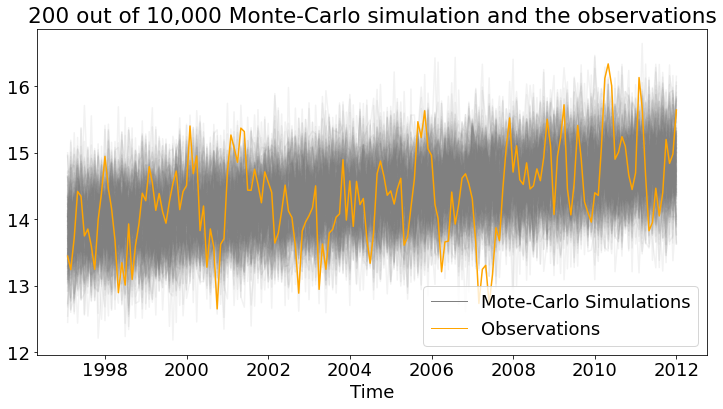

In [18]:
simulation_list = []
plt.figure(figsize=(12,6))
for i in range(10000):
    x = one_simulation()
    if i <= 200:
        plt.plot(si_short.index, x, 'grey', alpha = 0.1)
    simulation_list.append(x)

plt.plot(si_short, 'orange')
plt.xlabel('Time')
plt.title('200 out of 10,000 Monte-Carlo simulation and the observations')
custom_lines = [Line2D([0], [0], color='grey', lw=1), Line2D([0], [0], color='orange', lw=1)] # unbind legend and real data
plt.legend(custom_lines, ['Mote-Carlo Simulations', 'Observations'], loc = 'lower right')

Yes, I consider the observed time series a potential realisation of your stochastic model since it falls into the shaded area perfectly.

__2.b)	In a second step, generate another 10’000 realisations for future time steps (Jan 2012 to Feb 2025), based on the extrapolated trend you estimated in part 1 of this exercise. Exploit the information of the last observations in order to reduce uncertainty in your forecast by initialising the AR(1) process at the last observational value. Add the respective simulations to the plot of 2.a).__

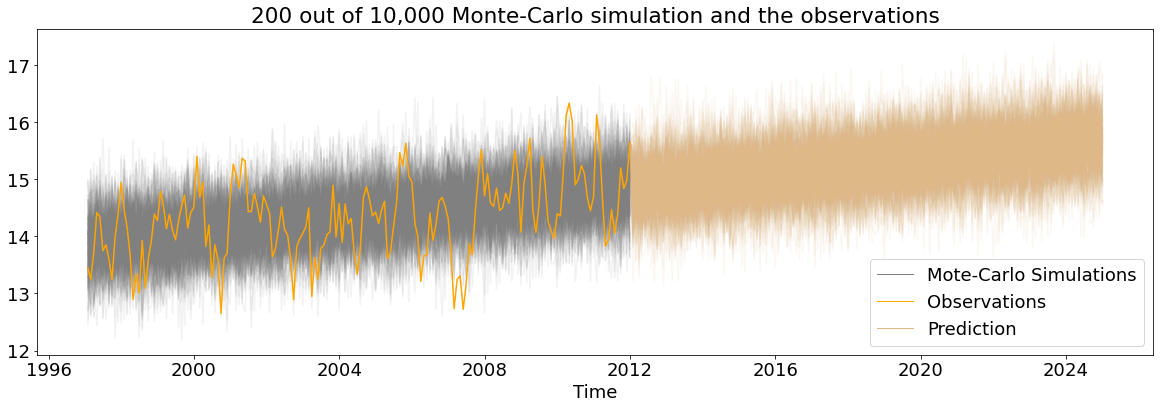

In [19]:
new_time_array = np.arange('2012-01', '2025-02', dtype='datetime64[M]')
simulation_list_long = []
plt.figure(figsize=(20,6))
for i in range(10000):
    x = one_simulation(intercept = (179*slope+intercept), # intercept starting from the Dec 2012
                         slope = slope,
                         autocorr = autocorr,
                         sigma_w = sigma_w,
                         obs_num = 157, # Jan 2012 to Feb 2025
                         ini_epi = residuals[-1] - residuals[-2])
    x[0] = si_short[-1] # Exploit the information of the last observations in order to reduce uncertainty
    simulation_list_long.append(x)
    if i <= 200:
        #plt.plot(new_time_array, x, 'grey', alpha = 0.1)
        plt.plot(new_time_array, x, 'burlywood', alpha = 0.1)
        plt.plot(si_short.index, simulation_list[i], 'grey', alpha = 0.1)

plt.plot(si_short, 'orange')
plt.xlabel('Time')
plt.title('200 out of 10,000 Monte-Carlo simulation and the observations')
custom_lines = [Line2D([0], [0], color='grey', lw=1), Line2D([0], [0], color='orange', lw=1), Line2D([0], [0], color='burlywood', lw=1)] # unbind legend and real data
plt.legend(custom_lines, ['Mote-Carlo Simulations', 'Observations', 'Prediction'], loc = 'lower right')

__2.c)	Plot the median of all (past and future) realisations for each month. With the function ```plt.fill_between()``` you can plot area between (1) the interquartile range and (2) the 2.5 and 97.5 percentile and (3) the minimum and maximum value per month. Use different transparency for the different ranges controlled by the function argument alpha. Further add the estimated trend line (dotted linestyle) and check whether the simulated values agree with your model. How well do the statistical characteristics of your simulations compare with observed time series?__

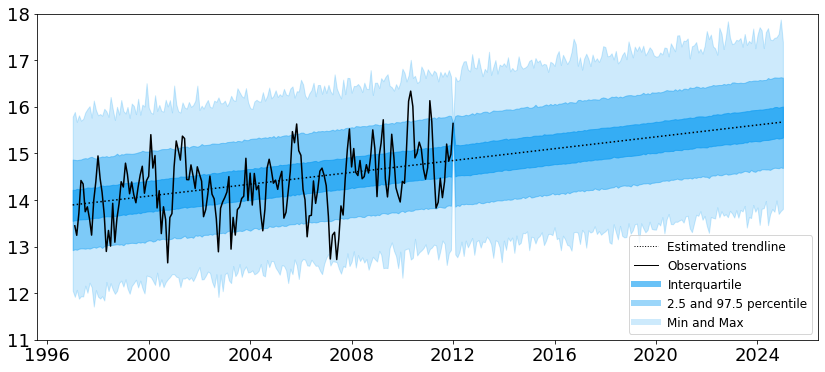

In [20]:
# merge all simulations into a dataframe
df1 = pd.DataFrame(simulation_list, columns = si_short.index)
df2 = pd.DataFrame(simulation_list_long, columns = new_time_array)
df = pd.concat([df1, df2], axis=1, join='inner')
#df.head()

# define quantiles
q25 = df.quantile(q = 0.25, axis = 0)
q75 = df.quantile(q = 0.75, axis = 0)
q025 = df.quantile(q = 0.025, axis = 0)
q975 = df.quantile(q = 0.975, axis = 0)
qmin = df.min(axis = 0)
qmax = df.max(axis = 0)

# plot
timeSpan = np.arange('1997-01', '2025-02', dtype='datetime64[M]')
plt.figure(figsize=(14,6))
plt.plot(timeSpan,[(i*slope+intercept) for i in range(1,338)],color='black', linestyle=':')
plt.fill_between(timeSpan, q25, q75,color='#069AF3', alpha = 0.6)
plt.fill_between(timeSpan, q025, q975,color='#069AF3', alpha = 0.4)
plt.fill_between(timeSpan, qmin, qmax,color='#069AF3', alpha = 0.2)
plt.ylim([11, 18])
plt.plot(si_short, 'black')

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='black',linestyle=':', lw=1),
                Line2D([0], [0], color='black', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

plt.legend(custom_lines, ['Estimated trendline', 'Observations', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'lower right', fontsize = 12)

Overall, the simulated values agree with our model; and the simulations are comparable with the observations since the observed time series mostly stay between the 2.5 and 97.5 percentile.

## 3. Forecast and ”Reality” – a little excursus

__3.a)	Load the extended observational dataset, observations ```FS2022_SI_obs_long.pkl``` into your notebook. Take the plot of your probabilistic realisations of exercise 2.c) and add the observations from Jan 2012 to Feb 2022 to the same figure.__

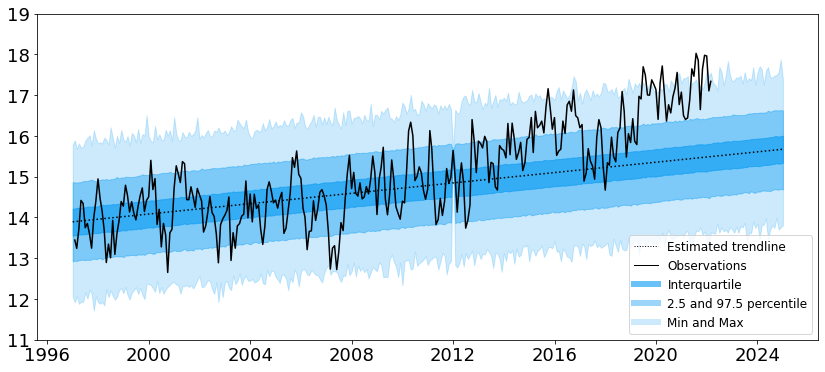

In [21]:
# Load the data
si_long = pd.read_pickle(os.path.join(dir_in_data,'FS2022_SI_obs_long.pkl'))

timeSpan = np.arange('1997-01', '2025-02', dtype='datetime64[M]')
plt.figure(figsize=(14,6))
plt.plot(timeSpan,[(i*slope+intercept) for i in range(1,338)],color='black', linestyle=':')
plt.fill_between(timeSpan, q25, q75,color='#069AF3', alpha = 0.6)
plt.fill_between(timeSpan, q025, q975,color='#069AF3', alpha = 0.4)
plt.fill_between(timeSpan, qmin, qmax,color='#069AF3', alpha = 0.2)
plt.ylim([11, 19])
plt.plot(si_long, 'black')

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='black',linestyle=':', lw=1),
                Line2D([0], [0], color='black', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

plt.legend(custom_lines, ['Estimated trendline', 'Observations', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'lower right', fontsize = 12)

__3.b)	Would you say your model captured the observations from Jan 2012 to Feb 2022 well? Are these more recent observations a result of internal variability of the system?__  

No, the model failed to captured the later observations. Thus, we deduce that the recent observations result from external mechanism such as climate changes instead of internal envolution.

__3.c) Could it be that there is a stronger trend than estimated from the Jan 1997 to Dec 2012 data? Fit a quadratic function $x_t=\beta_0+\beta_1*t + \beta_2*t^2+\epsilon_t$ to the long time series from  Jan 1997 to Feb 2022. You can use the function ```np.polyfit()``` for this purpose. Plot the observations together with your new fit and your previous linear estimate.__

beta_0: 14.07
beta_1: -2.20e-03
beta_2: 4.40e-05


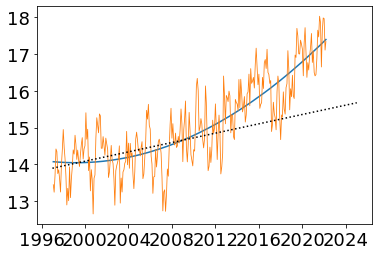

In [22]:
beta_2_q, beta_1_q, beta_0_q = np.polyfit(np.arange(len(si_long)), si_long, deg = 2)

print('beta_0: %.2f' %beta_0_q)
print('beta_1: %.2e' %beta_1_q)
print('beta_2: %.2e' %beta_2_q)

plt.plot(si_long.index, [(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in np.arange(len(si_long))])
plt.plot(si_long, lw = 0.8)
plt.plot(timeSpan,[(i*slope+intercept) for i in range(1,338)],color='black', linestyle=':')

From the plot we could tell that the quadratic trend is a better estimate than linear trend estimation.

__3.d) Redo the Monte-Carlo simulations from Jan 1997 to Feb 2025 but this time using your quadratic fit and remember to also re-estimate the noise term $\epsilon_t$ based on the newly available extended observational dataset. Again, make sure to use the last observation available when initialising the AR(1) process for future values. Do a quantile plot as in 2.c) but now for the quadratic trend and within the same plot additionally plot the long observations.__

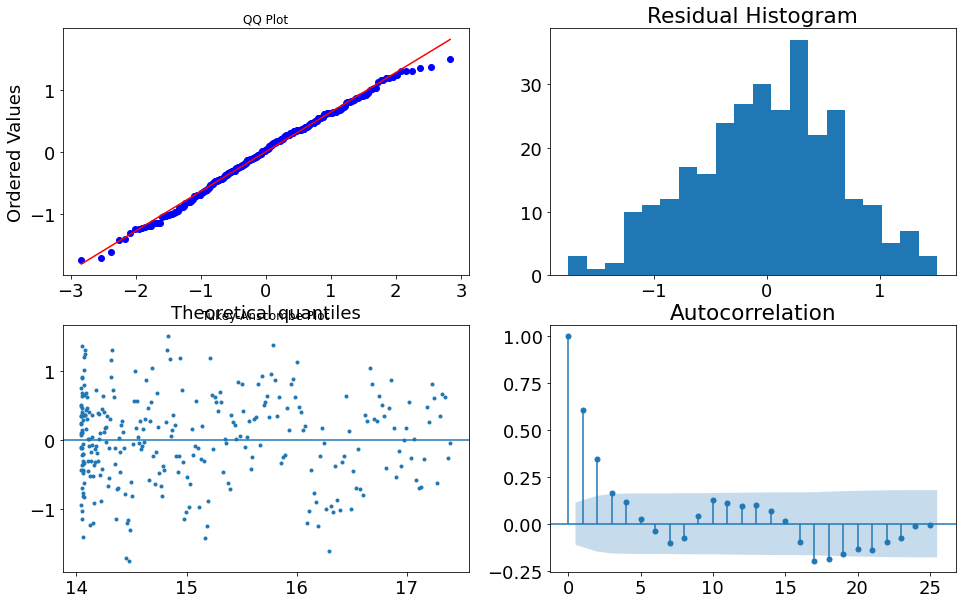

In [23]:
y_hat = [(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in np.arange(len(si_long))]
residuals = [si_long[i] - y_hat[i] for i in np.arange(len(si_long))]

fig, axs = plt.subplots(2,2, figsize = (16,10))
res = stats.probplot(residuals, plot = axs[0][0])
axs[0][0].set_title('QQ Plot', size = 12)
axs[0][1].hist(residuals, bins=20)
axs[0][1].set_title('Residual Histogram')
axs[1][0].plot(y_hat, residuals, '.')
axs[1][0].axhline(0)
axs[1][0].set_title('Tukey-Anscombe Plot', size = 12)
statsmodels.graphics.tsaplots.plot_acf(pd.Series(residuals), ax = axs[1][1])
plt.show()

Again, we observe autocorrelation

Figure(432x288)


/usr/local/Miniconda3-envs/envs/2021/envs/iacpy3_2021/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


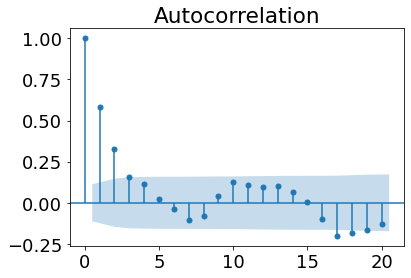

In [24]:
# pre-whitening
W = [((si_long[i] - autocorr * si_long[i-1]) / (1 - autocorr)) for i in range(1, len(si_long))]
beta_2_q, beta_1_q, beta_0_q = np.polyfit(np.arange(len(si_long)-1), W, deg = 2)
y_hat2 = [(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in np.arange(len(si_long)-1)]
residuals2 = [W[i] - y_hat2[i] for i in range(len(si_long)-1)]
print(statsmodels.graphics.tsaplots.plot_acf(pd.Series(residuals2), lags = 20))

# We could see autocorrelation are all non-significant, thus we don't need further iteration.
residuals = residuals2
autocorr = pacf(pd.Series(residuals))[1]
mean, sigma_w = stats.norm.fit(pd.Series([(residuals[i] - residuals[i-1] * autocorr) for i in range(1, len(residuals))])[:-1])

In [25]:
def one_simulation(beta_0_q = beta_0_q, beta_1_q = beta_1_q, beta_2_q = beta_2_q, autocorr = autocorr, sigma_w = sigma_w, obs_num = len(si_long), ini_epi = None):
    random_truncate = random.randint(1, 10) # randomly truncate the epi to avoid initialization problem
    wt = np.random.normal(mean, sigma_w, obs_num + random_truncate)
    epi = np.array([None] * (obs_num + random_truncate))
    if ini_epi is None:
        for i in range(len(epi)):
            if i==0:
                epi[i] = wt[i]
            else:
                epi[i] = epi[i-1] * autocorr + wt[i]  
        epi = epi[random_truncate:]
        x = [(beta_0_q + beta_1_q * i + beta_2_q * i * i + epi[i]) for i in np.arange(obs_num)]
    else:
        for i in range(len(epi)):
            if i==0:
                epi[i] = ini_epi
            else:
                epi[i] = epi[i-1] * autocorr + wt[i]  
        epi = epi[random_truncate:]
        x = [(beta_0_q + beta_1_q * i + beta_2_q * i * i + epi[i]) for i in np.arange(obs_num)]
    return x

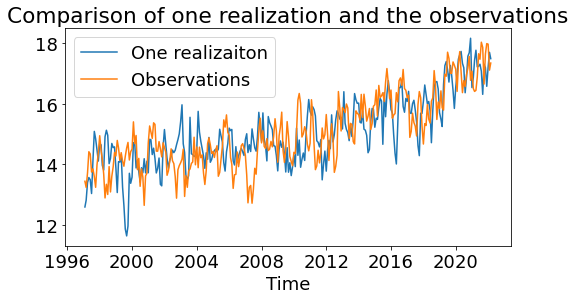

In [26]:
random.seed(12)
x = one_simulation()

# plot
plt.figure(figsize=(8,4))
plt.plot(si_long.index, x)
plt.plot(si_long)
plt.xlabel('Time')
plt.title('Comparison of one realization and the observations')
plt.legend(['One realizaiton','Observations'], loc ="upper left")

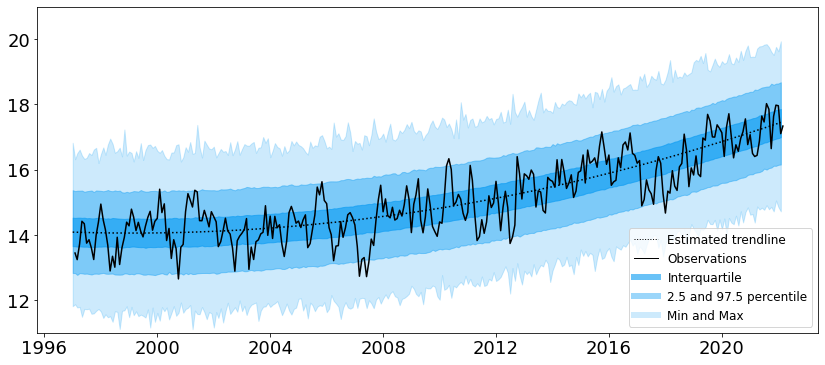

In [36]:
simulation_list = []
for i in range(10000):
    x = one_simulation()
    simulation_list.append(x)

# merge all simulations into a dataframe
df3 = pd.DataFrame(simulation_list, columns = si_long.index)
#df.head()

# define quantiles
q25 = df3.quantile(q = 0.25, axis = 0)
q75 = df3.quantile(q = 0.75, axis = 0)
q025 = df3.quantile(q = 0.025, axis = 0)
q975 = df3.quantile(q = 0.975, axis = 0)
qmin = df3.min(axis = 0)
qmax = df3.max(axis = 0)

# plot
timeSpan = np.arange('1997-01', '2022-03', dtype='datetime64[M]')
plt.figure(figsize = (14,6))
plt.plot(timeSpan,[(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in range(1,303)],color='black', linestyle=':')
plt.fill_between(timeSpan, q25, q75,color='#069AF3', alpha = 0.6)
plt.fill_between(timeSpan, q025, q975,color='#069AF3', alpha = 0.4)
plt.fill_between(timeSpan, qmin, qmax,color='#069AF3', alpha = 0.2)
plt.ylim([11, 21])
plt.plot(si_long, 'black')

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='black',linestyle=':', lw=1),
                Line2D([0], [0], color='black', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

plt.legend(custom_lines, ['Estimated trendline', 'Observations', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'lower right', fontsize = 12)

__3.e)	Look at the end of your forecast period. Do you think that the observations will be within the range of your predictions in 2024? Can you extrapolate your forecast into the far future and make realistic predictions of the storminess in e.g. 100 or 200 years? Answer in 2-3 Sentences.__

The observations are reasonably in the range of the model's prediction in 2024. However, it is not realistic to extropolate the model to the far future, e.g. 100-200 years, since the storm wind speed can reach a physical boundary and become inrealistic.

## 4. Uncertainty of impact and mitigation costs
### Impact costs

__4.a) Given the information above, figure out the parameters and expression of the impact costs, including some sort of exponential function of SI. There is no strict right or wrong function. Generate a function that looks meaningful to you and explain why. Plot the impact costs as a function of SI ranging from 15 m s$^{-1}$ to 24 m s$^{-1}$.__


Text(0, 0.5, 'Cost ($)')

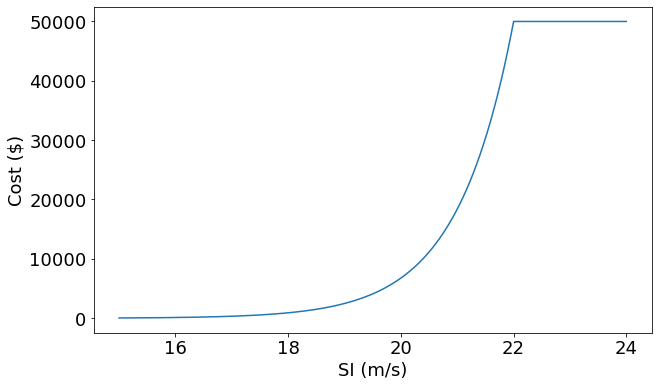

In [28]:
def cost_function(SI, bottom = 15, upper = 22, stop = 24, totalLoss = 50000):
    if SI <= 15:
        return 0
    elif SI <=22:
        A = 50000 / (np.exp(upper) - np.exp(bottom))
        B = A * np.exp(bottom)
        return (A * np.exp(SI) - B)
    else:
        return totalLoss
    
x = np.linspace(15,24,1000)
cost_list = [cost_function(i) for i in x]
plt.figure(figsize = (10, 6))
plt.plot(x, cost_list)
plt.xlabel('SI (m/s)')
plt.ylabel('Cost ($)')

According to our cost function, if SI is less than 15 m/s, we consider no damage and from 15 to 22 as exponentially damaging. When SI reaches 22 m/s, the properties like houses can be seriously damaged and cannot function further. Thus, from 22 m/s we conclude a total loss of 50,000$ until the upper threshold 24 m/s.

__4.b)	Considering the distribution of the March 2022 forecasts, how high are the impact costs in terms of the median, 2.5% and 97.5% quantile?__

In [55]:
simulation_list = []
for i in range(10000):
    x = one_simulation(obs_num = len(si_long)+1)
    simulation_list.append(x)

# merge all simulations into a dataframe
df4 = pd.DataFrame(simulation_list, columns = [i for i in range(len(si_long) + 1)])
impact_cost_202203 = [cost_function(i) for i in df4.loc[:,302]]

print(' 2.5 percent quantile: %.2f $' %np.percentile(impact_cost_202203,  2.5))
print('50.0 percent quantile: %.2f $' %np.percentile(impact_cost_202203, 50.0))
print('97.5 percent quantile: %.2f $' %np.percentile(impact_cost_202203, 97.5))

 2.5 percent quantile: 103.54 $
50.0 percent quantile: 485.85 $
97.5 percent quantile: 1793.71 $


__4.c)	Plot the temporal evolution of mean, median, interquartile range, 2.5 and 97.5 percentile, and the minimum and maximum impact cost for the whole duration of your forecast (i.e., the 36 months from Mar 2022 – Feb 2025). Additionally, have a look at the respective (mean, median, ...) cumulative costs as a function of forecast lead-time until 2025. Make sure to apply the different functions (```pd.DataFrame.quantile(.)``` / ```your_cost_function(.)``` / ```pd.DataFrame.cumsum(.)```) in a sensible order.__

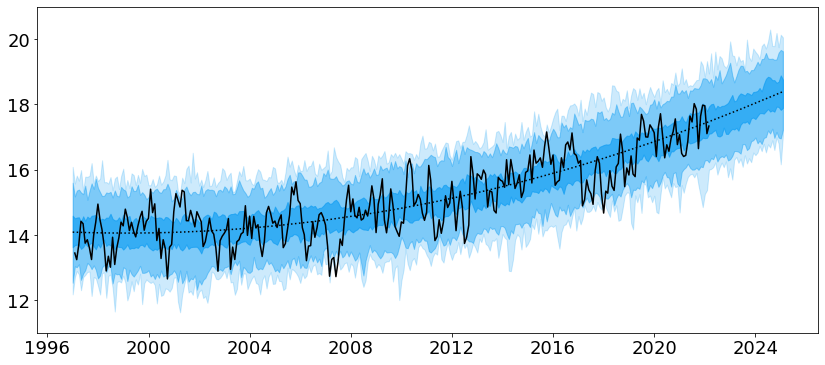

In [63]:
newTimeSpan = np.arange('1997-01', '2025-03', dtype='datetime64[M]')
simulation_list = []
for i in range(100):
    x = one_simulation(obs_num = len(si_long)+36)
    simulation_list.append(x)

# merge all simulations into a dataframe
df5 = pd.DataFrame(simulation_list, columns = [i for i in range(len(si_long) + 36)])
#impact_cost_202203 = [cost_function(i) for i in df5.loc[:,302]]

# define quantiles
q25 = df5.quantile(q = 0.25, axis = 0)
qmedian = df5.quantile(q = 0.5, axis = 0)
q75 = df5.quantile(q = 0.75, axis = 0)
q025 = df5.quantile(q = 0.025, axis = 0)
q975 = df5.quantile(q = 0.975, axis = 0)
qmin = df5.min(axis = 0)
qmax = df5.max(axis = 0)
qmean = df5.mean(axis = 0)

# plot
plt.figure(figsize = (14,6))
plt.plot(newTimeSpan,[(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in range(1,339)],color='black', linestyle=':')
plt.fill_between(newTimeSpan, q25, q75,color='#069AF3', alpha = 0.6)
plt.fill_between(newTimeSpan, q025, q975,color='#069AF3', alpha = 0.4)
plt.fill_between(newTimeSpan, qmin, qmax,color='#069AF3', alpha = 0.2)
plt.ylim([11, 21])
plt.plot(si_long, 'black')

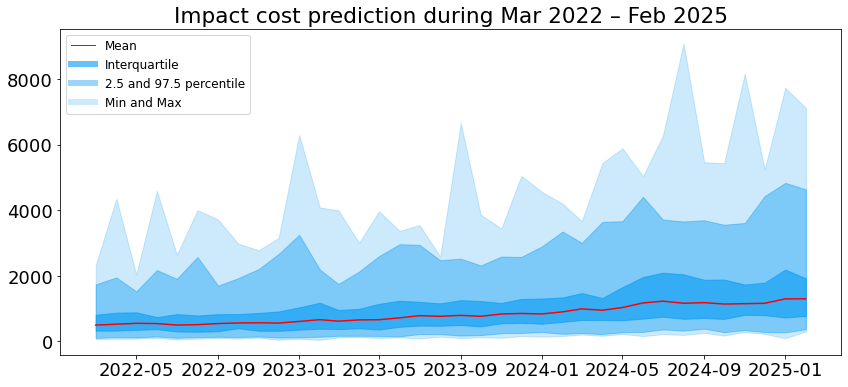

In [106]:
q25_cost = pd.Series([cost_function(i) for i in q25[-36:]], index = newTimeSpan[-36:])
qmedian_cost = pd.Series([cost_function(i) for i in qmedian[-36:]], index = newTimeSpan[-36:])
q75_cost = pd.Series([cost_function(i) for i in q75[-36:]], index = newTimeSpan[-36:])
q025_cost = pd.Series([cost_function(i) for i in q025[-36:]], index = newTimeSpan[-36:])
q975_cost = pd.Series([cost_function(i) for i in q975[-36:]], index = newTimeSpan[-36:])
qmin_cost = pd.Series([cost_function(i) for i in qmin[-36:]], index = newTimeSpan[-36:])
qmax_cost = pd.Series([cost_function(i) for i in qmax[-36:]], index = newTimeSpan[-36:])
qmean_cost = pd.Series([cost_function(i) for i in qmean[-36:]], index = newTimeSpan[-36:])

plt.figure(figsize = (14,6))
plt.fill_between(newTimeSpan[-36:], q25_cost, q75_cost,color='#069AF3', alpha = 0.6)
plt.fill_between(newTimeSpan[-36:], q025_cost, q975_cost,color='#069AF3', alpha = 0.4)
plt.fill_between(newTimeSpan[-36:], qmin_cost, qmax_cost,color='#069AF3', alpha = 0.2)
plt.plot(newTimeSpan[-36:], qmean_cost, color = 'red')
plt.title('Impact cost prediction during Mar 2022 – Feb 2025')

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

plt.legend(custom_lines, ['Mean', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'upper left', fontsize = 12)

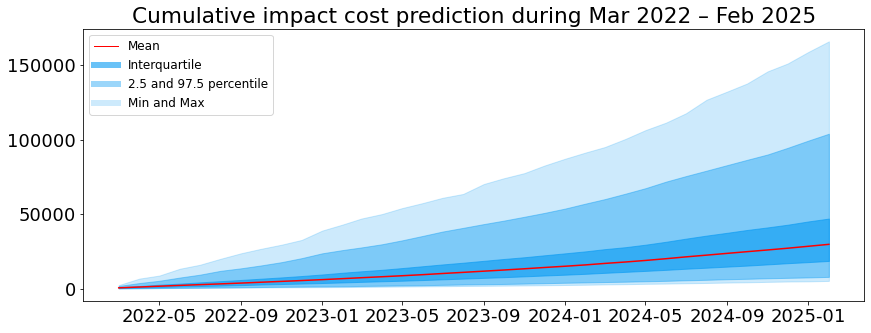

In [107]:
q25_cost_sum = pd.DataFrame.cumsum(q25_cost)
qmedian_cost_sum = pd.DataFrame.cumsum(qmedian_cost)
q75_cost_sum = pd.DataFrame.cumsum(q75_cost)
q025_cost_sum = pd.DataFrame.cumsum(q025_cost)
q975_cost_sum = pd.DataFrame.cumsum(q975_cost)
qmin_cost_sum = pd.DataFrame.cumsum(qmin_cost)
qmax_cost_sum = pd.DataFrame.cumsum(qmax_cost)
qmean_cost_sum = pd.DataFrame.cumsum(qmean_cost)

plt.figure(figsize = (14,5))
plt.fill_between(newTimeSpan[-36:], q25_cost_sum, q75_cost_sum,color='#069AF3', alpha = 0.6)
plt.fill_between(newTimeSpan[-36:], q025_cost_sum, q975_cost_sum,color='#069AF3', alpha = 0.4)
plt.fill_between(newTimeSpan[-36:], qmin_cost_sum, qmax_cost_sum,color='#069AF3', alpha = 0.2)
plt.plot(newTimeSpan[-36:], qmean_cost_sum, color = 'red')
plt.title('Cumulative impact cost prediction during Mar 2022 – Feb 2025')

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

plt.legend(custom_lines, ['Mean', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'upper left', fontsize = 12)

__4.d)	Discuss if you would invest in either A, B or none of the options for the time horizon of your forecast (i.e., the 36 months from Mar 2022 – Feb 2025). For this purpose, plot the damage functions with the respective measures A and B in place (as in 4.a), and examine the temporal evolution of the _mean_ expected (cumulative) damage (as in 4.c).__

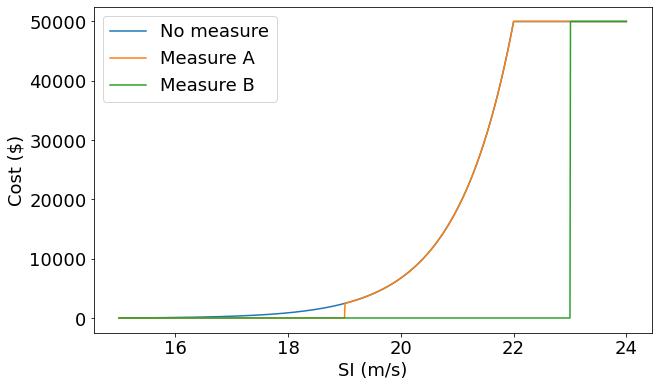

In [114]:
def cost_function(SI, measure = None, bottom = 15, upper = 22, stop = 24, totalLoss = 50000):
    if measure is None:
        if SI <= 15:
            return 0
        elif SI <=22:
            A = 50000 / (np.exp(upper) - np.exp(bottom))
            B = A * np.exp(bottom)
            return (A * np.exp(SI) - B)
        else:
            return totalLoss
    elif measure == 'A':
        if SI <= 19:
            return 0
        elif SI <=22:
            A = 50000 / (np.exp(upper) - np.exp(bottom))
            B = A * np.exp(bottom)
            return (A * np.exp(SI) - B)
        else:
            return totalLoss
    elif measure == 'B':
        if SI <= 23:
            return 0
        else:
            return totalLoss
    else:
        raise ValueError('Wrong measure input')
    
x = np.linspace(15,24,1000)
cost_list_noMeasure = [cost_function(i) for i in x]
cost_list_A = [cost_function(i, measure = 'A') for i in x]
cost_list_B = [cost_function(i, measure = 'B') for i in x]
plt.figure(figsize = (10, 6))
plt.plot(x, cost_list_noMeasure)
plt.plot(x, cost_list_A)
plt.plot(x, cost_list_B)
plt.xlabel('SI (m/s)')
plt.ylabel('Cost ($)')
plt.legend(['No measure','Measure A','Measure B'])

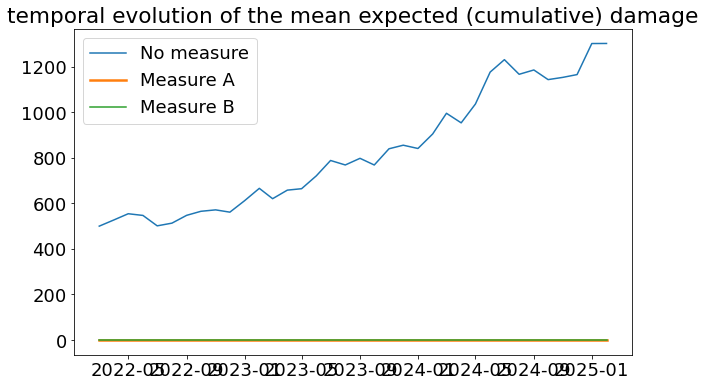

In [126]:
qmean_cost_noMeasure = pd.Series([cost_function(i) for i in qmean[-36:]], index = newTimeSpan[-36:])
qmean_cost_A = pd.Series([cost_function(i, measure = 'A') for i in qmean[-36:]], index = newTimeSpan[-36:])
qmean_cost_B = pd.Series([cost_function(i, measure = 'B') for i in qmean[-36:]], index = newTimeSpan[-36:])

plt.figure(figsize = (10, 6))
plt.plot(qmean_cost_noMeasure)
plt.plot(qmean_cost_A, lw = 2.5)
plt.plot(qmean_cost_B)
plt.title('temporal evolution of the mean expected (cumulative) damage')
plt.legend(['No measure','Measure A','Measure B'])

According to our simulation, since during Mar 2022 – Feb 2025, the maximum of mean SI simulated is 18.39 below the threshold of measure A. Therefore, even the cheaper measure A (shutter) can effictively reduce the risk and cost. Thus, we prefer measure A.

__4.e)	Assuming you would invest for the next 10 years; qualitatively discuss which option makes most sense. Which uncertainties do you need to take into consideration for your decision?__

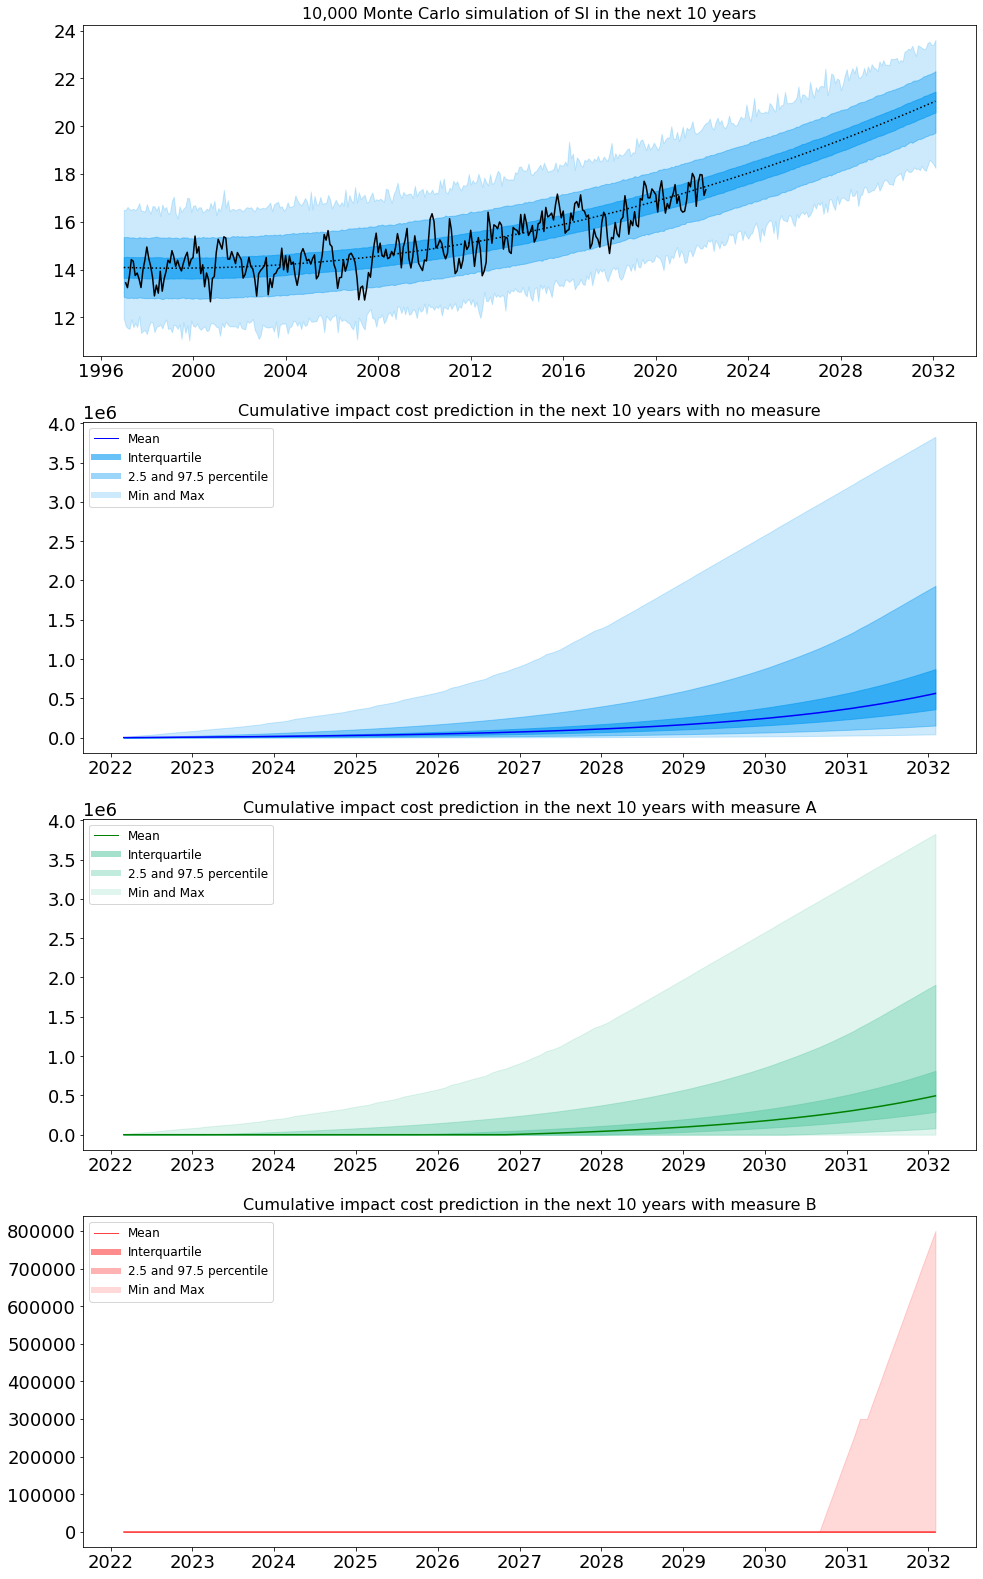

In [174]:
fig, axs = plt.subplots(4,1, figsize = (16,28))

newTimeSpan = np.arange('1997-01', '2032-03', dtype='datetime64[M]')
simulation_list_10yr = []
for i in range(10000):
    x = one_simulation(obs_num = len(newTimeSpan))
    simulation_list_10yr.append(x)

# merge all simulations into a dataframe
df6 = pd.DataFrame(simulation_list_10yr, columns = [i for i in range(len(newTimeSpan))])
#impact_cost_202203 = [cost_function(i) for i in df5.loc[:,302]]

# define quantiles
q25 = df6.quantile(q = 0.25, axis = 0)
qmedian = df6.quantile(q = 0.5, axis = 0)
q75 = df6.quantile(q = 0.75, axis = 0)
q025 = df6.quantile(q = 0.025, axis = 0)
q975 = df6.quantile(q = 0.975, axis = 0)
qmin = df6.min(axis = 0)
qmax = df6.max(axis = 0)
qmean = df6.mean(axis = 0)

axs[0].set_title('10,000 Monte Carlo simulation of SI in the next 10 years', fontsize = 16)
axs[0].plot(newTimeSpan,[(beta_0_q + beta_1_q * i + beta_2_q * i * i) for i in range(1,423)],color='black', linestyle=':')
axs[0].fill_between(newTimeSpan, q25, q75,color='#069AF3', alpha = 0.6)
axs[0].fill_between(newTimeSpan, q025, q975,color='#069AF3', alpha = 0.4)
axs[0].fill_between(newTimeSpan, qmin, qmax,color='#069AF3', alpha = 0.2)
#plt.ylim([11, 21])
axs[0].plot(si_long, 'black')

# second plot
q25_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in q25[-120:]], index = newTimeSpan[-120:]))
qmedian_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in qmedian[-120:]], index = newTimeSpan[-120:]))
q75_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in q75[-120:]], index = newTimeSpan[-120:]))
q025_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in q025[-120:]], index = newTimeSpan[-120:]))
q975_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in q975[-120:]], index = newTimeSpan[-120:]))
qmin_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in qmin[-120:]], index = newTimeSpan[-120:]))
qmax_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in qmax[-120:]], index = newTimeSpan[-120:]))
qmean_cost_sum = pd.DataFrame.cumsum(pd.Series([cost_function(i) for i in qmean[-120:]], index = newTimeSpan[-120:]))

axs[1].fill_between(newTimeSpan[-120:], q25_cost_sum, q75_cost_sum,color='#069AF3', alpha = 0.6)
axs[1].fill_between(newTimeSpan[-120:], q025_cost_sum, q975_cost_sum,color='#069AF3', alpha = 0.4)
axs[1].fill_between(newTimeSpan[-120:], qmin_cost_sum, qmax_cost_sum,color='#069AF3', alpha = 0.2)
axs[1].plot(newTimeSpan[-120:], qmean_cost_sum, color = 'blue')
axs[1].set_title('Cumulative impact cost prediction in the next 10 years with no measure', fontsize = 16)

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='#069AF3', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#069AF3', alpha = 0.2, lw=6)]

axs[1].legend(custom_lines, ['Mean', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'upper left', fontsize = 12)

# third plot
q25_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in q25[-120:]], index = newTimeSpan[-120:]))
qmedian_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in qmedian[-120:]], index = newTimeSpan[-120:]))
q75_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in q75[-120:]], index = newTimeSpan[-120:]))
q025_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in q025[-120:]], index = newTimeSpan[-120:]))
q975_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in q975[-120:]], index = newTimeSpan[-120:]))
qmin_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in qmin[-120:]], index = newTimeSpan[-120:]))
qmax_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in qmax[-120:]], index = newTimeSpan[-120:]))
qmean_cost_sum_A = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'A') for i in qmean[-120:]], index = newTimeSpan[-120:]))

axs[2].fill_between(newTimeSpan[-120:], q25_cost_sum_A, q75_cost_sum_A,color='#66CDAA', alpha = 0.6)
axs[2].fill_between(newTimeSpan[-120:], q025_cost_sum_A, q975_cost_sum_A,color='#66CDAA', alpha = 0.4)
axs[2].fill_between(newTimeSpan[-120:], qmin_cost_sum_A, qmax_cost_sum_A,color='#66CDAA', alpha = 0.2)
axs[2].plot(newTimeSpan[-120:], qmean_cost_sum_A, color = 'green')
axs[2].set_title('Cumulative impact cost prediction in the next 10 years with measure A', fontsize = 16)

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='green', lw=1),
                Line2D([0], [0], color='#66CDAA', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#66CDAA', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#66CDAA', alpha = 0.2, lw=6)]

axs[2].legend(custom_lines, ['Mean', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'upper left', fontsize = 12)

# fourth plot
q25_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in q25[-120:]], index = newTimeSpan[-120:]))
qmedian_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in qmedian[-120:]], index = newTimeSpan[-120:]))
q75_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in q75[-120:]], index = newTimeSpan[-120:]))
q025_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in q025[-120:]], index = newTimeSpan[-120:]))
q975_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in q975[-120:]], index = newTimeSpan[-120:]))
qmin_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in qmin[-120:]], index = newTimeSpan[-120:]))
qmax_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in qmax[-120:]], index = newTimeSpan[-120:]))
qmean_cost_sum_B = pd.DataFrame.cumsum(pd.Series([cost_function(i, measure = 'B') for i in qmean[-120:]], index = newTimeSpan[-120:]))

axs[3].fill_between(newTimeSpan[-120:], q25_cost_sum_B, q75_cost_sum_B,color='#FF4040', alpha = 0.6)
axs[3].fill_between(newTimeSpan[-120:], q025_cost_sum_B, q975_cost_sum_B,color='#FF4040', alpha = 0.4)
axs[3].fill_between(newTimeSpan[-120:], qmin_cost_sum_B, qmax_cost_sum_B,color='#FF4040', alpha = 0.2)
axs[3].plot(newTimeSpan[-120:], qmean_cost_sum_B, color = '#FF4040')
axs[3].set_title('Cumulative impact cost prediction in the next 10 years with measure B', fontsize = 16)

# unbind legend and real data
custom_lines = [Line2D([0], [0], color='#FF4040', lw=1),
                Line2D([0], [0], color='#FF4040', alpha = 0.6, lw=6),
                Line2D([0], [0], color='#FF4040', alpha = 0.4, lw=6),
                Line2D([0], [0], color='#FF4040', alpha = 0.2, lw=6)]

axs[3].legend(custom_lines, ['Mean', 'Interquartile', '2.5 and 97.5 percentile', 'Min and Max'], loc = 'upper left', fontsize = 12)

According to the cumulative cost estimation of three choices in the next years, we would choose measure B with a base cost of 60,000$, but the damage cost is very likely zero since we are 95% confident that the measure B can bear all possible damages. Only in the worst situation we suffer damage, but the magnitude is way lower than the other two measures. However, we have to consider the uncertainty of the model itself, the model's simualtions' confidence interval. For the model itself, for a long timespan like 10 years, the model can be not realistic given not enough data, and the trend estimation can easily break the physical boundary in the long run.

__4.f)	Based on your storminess forecast, how would you protect your house in the long term in order to minimize costs? Argument how an interest rate of 5 % would affect your decision in 4.d) and 4.e).__

Based on our storminess forecast, we would choose measure B to minimize possible damage cost. Given an interest rate of 5%, we may have to think twice the current big investment of protection over potential tremendous cost in the far future. However, we still stick to measure B since the inflation is minor compared with the big discrepency between the estimated cost of measure B and the other two.